# Playing Atari Games with DQN

---

## From Q-table to Q-network

Last time, we learned about Q-Learning: an algorithm which produces a Q-table that an agent uses to find the best action to take given a state. The Q-table as a “cheat-sheet” helps us to find the maximum expected future reward of an action, given a current state. This was a good strategy — however, this is not scalable. As we see, producing and updating a Q-table can become ineffective in big state space environments.

Today, we’ll create a Deep Q Neural Network. Instead of using a Q-table, we’ll implement a Neural Network that takes a state and approximates Q-values for each action based on that state.


## A Quick View into DQN

The picture below will be the architecture of our Deep Q Learning. Our Deep Q Neural Network takes a stack of four frames as an input. These pass through its network, and output a vector of Q-values for each action possible in the given state. We need to take the biggest Q-value of this vector to find our best action.

In the beginning, the agent does really badly. But over time, it begins to associate frames (states) with best actions to do.

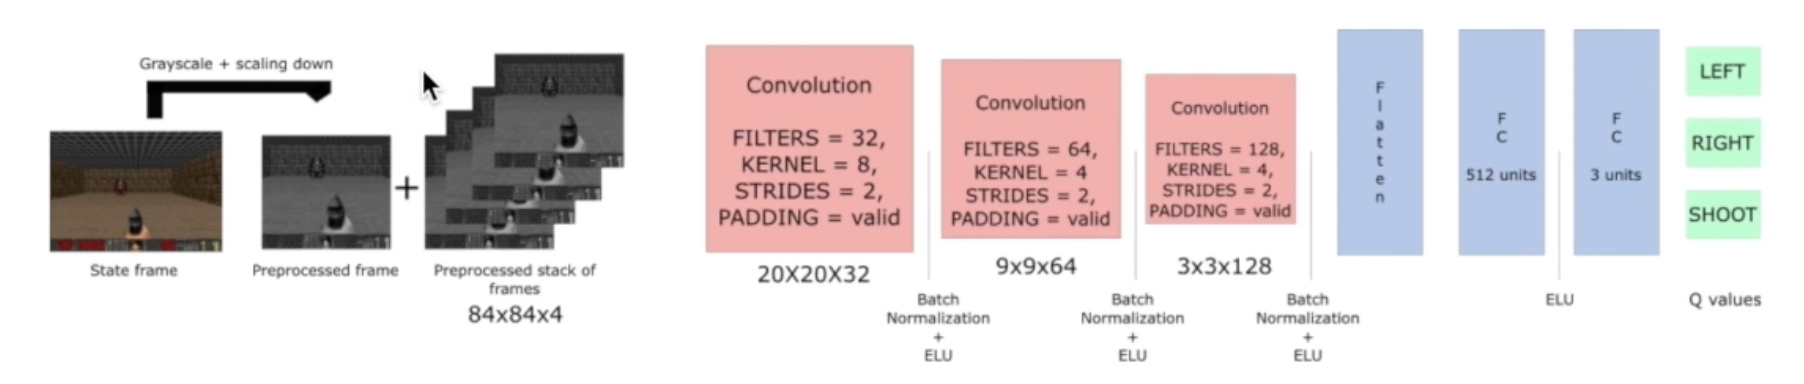

**paper**: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [6]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import os
import cv2 as cv

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%matplotlib inline

## OpenAI Gym and Atari Game

https://github.com/openai/gym

Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.

The Atari 2600 (or Atari Video Computer System or Atari VCS before November 1982) is a home video game console from Atari, Inc. Released on September 11, 1977.


In [2]:
# for atari game support
!pip install gym[atari]

     |████████████████████████████████| 542kB 7.4MB/s eta 0:00:01
  Created wheel for atari-py: filename=atari_py-0.2.9-cp36-cp36m-linux_x86_64.whl size=2526235 sha256=9cc28b515648523c6a3f7ac9917a274fa0007cdbbd18ef055eaeddbf34a596c9
  Stored in directory: /root/.cache/pip/wheels/95/89/16/266121570a9dc3c3e8d35c8699639ac3fd44a5fff456eec735
Successfully built atari-py


In [ ]:
env = gym.make('BreakoutDeterministic-v4')

frame = env.reset()
plt.figure()
plt.imshow(frame)

totalActions = env.action_space.n

print("Shape = ",frame.shape)
print("Action space size: Action  {}".format(totalActions))
print(env.unwrapped.get_action_meanings())

env.close()

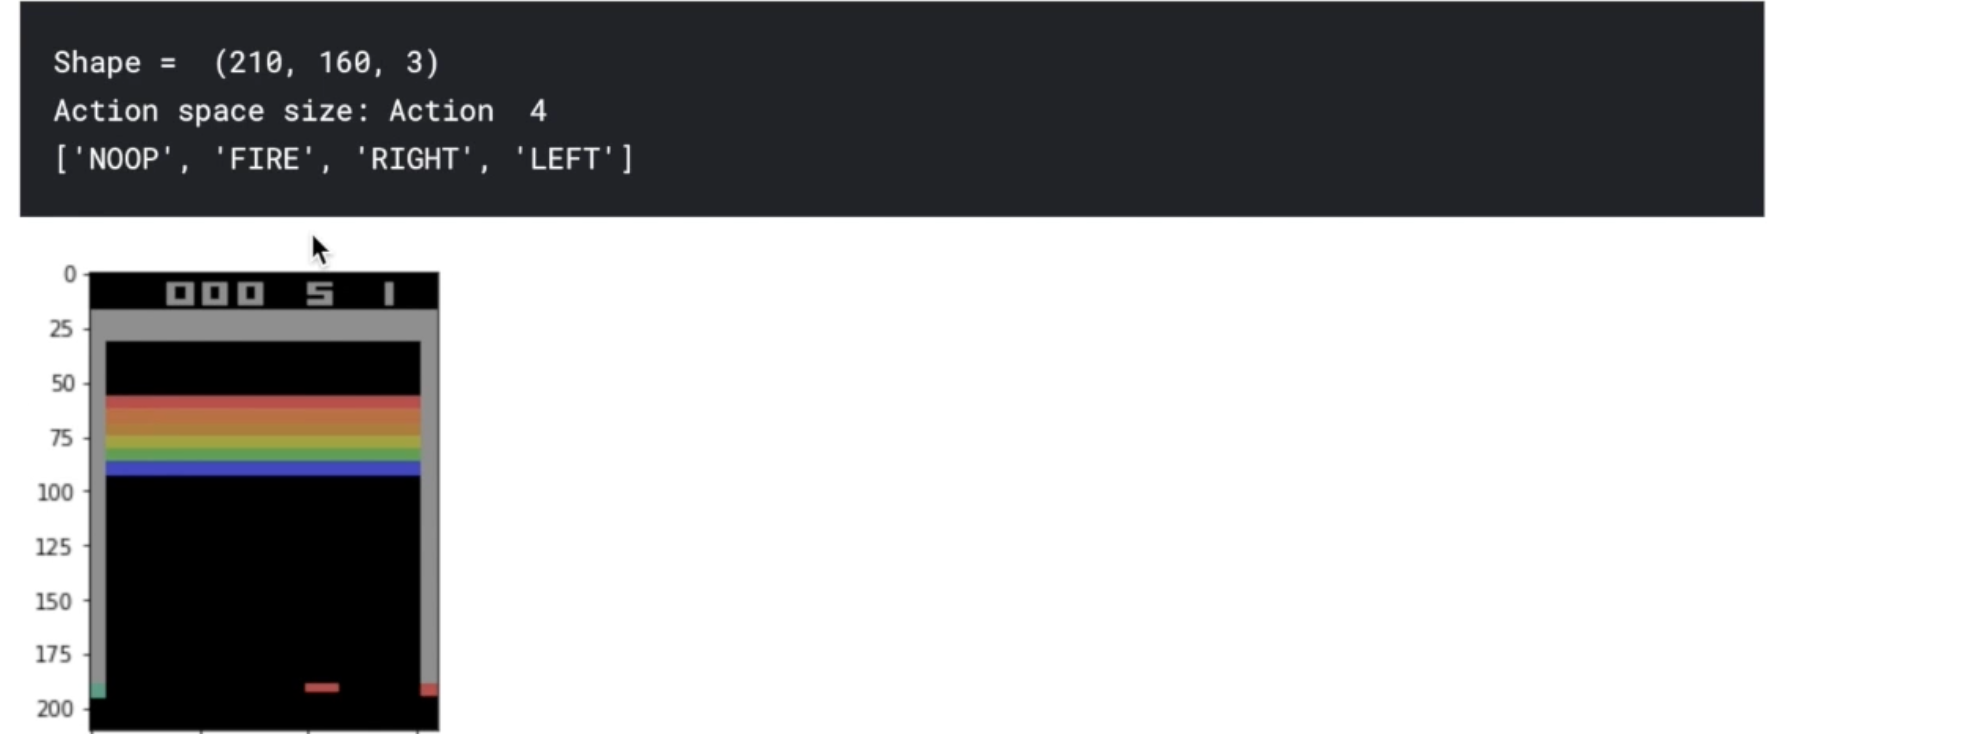

## Frame Preprocessing

Preprocessing is an important step. We want to reduce the complexity of our states to reduce the computation time needed for training.

First, we can grayscale each of our states. Color does not add important information (in our case, we just need to find the enemy and kill him, and we don’t need color to find him). This is an important saving, since we reduce our three colors channels (RGB) to 1 (grayscale).

Then we reduce the size of the frame, and we stack four sub-frames together. The stack operation will be done later in our code.

Why use stack? -- Can you tell me where the ball is going if not use stack?

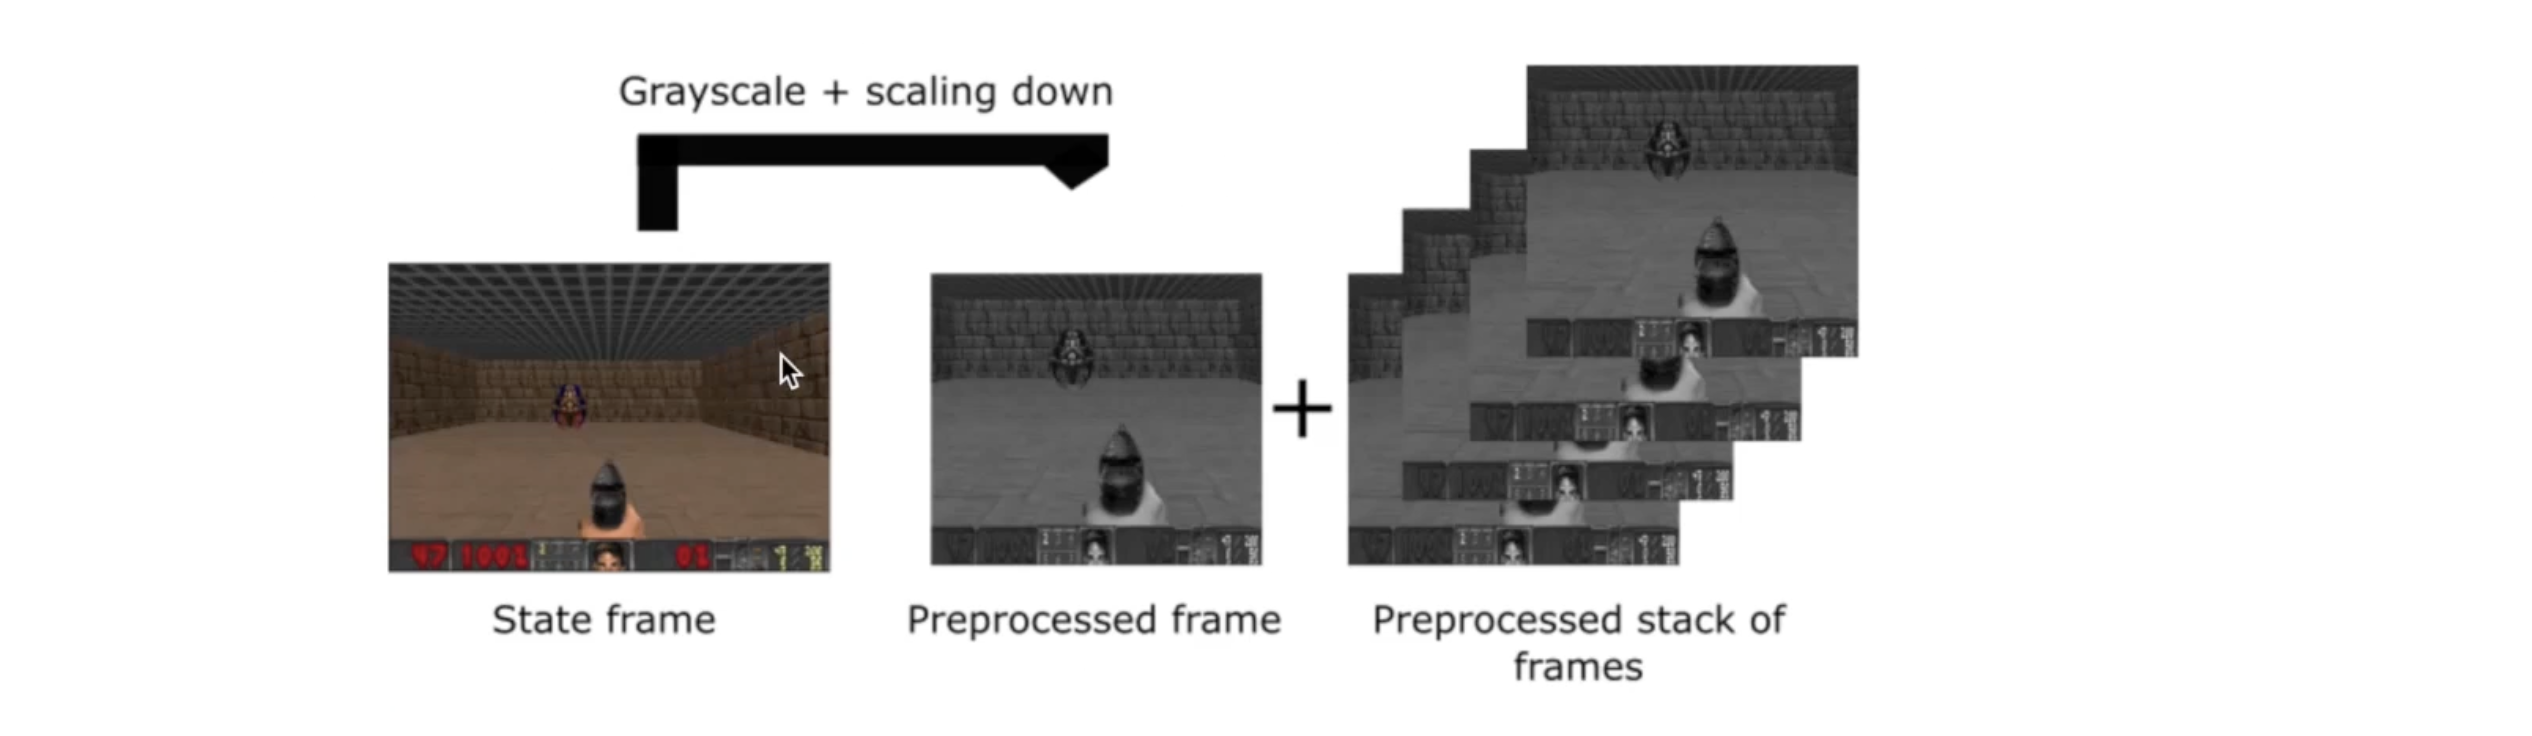

In [ ]:
def preprocess(img):
    grayImg = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    resized = cv.resize(grayImg,(84,110))
    preProcessedImg = resized[:84,:84]
    
    return preProcessedImg

In [ ]:
fig = plt.figure(figsize=(8,8))
newFrame = preprocess(frame)
print(newFrame.shape,newFrame.dtype)

fig.add_subplot(1,3,1)
plt.imshow(newFrame)

fig.add_subplot(1,3,2)
plt.imshow(frame)
plt.show()

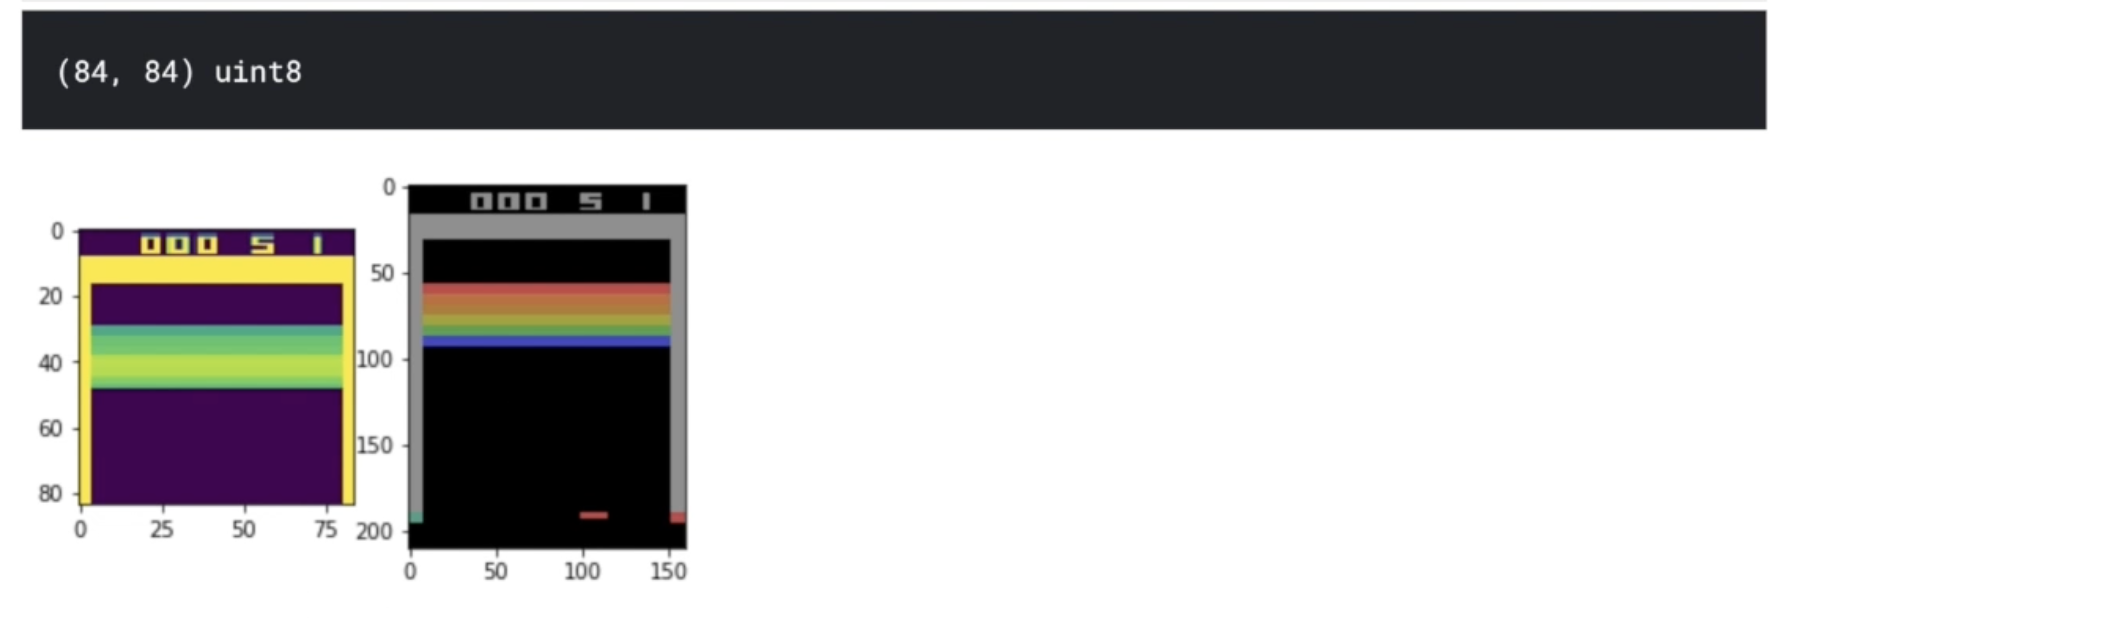

## Using Convolution Networks

The frames are processed by three convolution layers. These layers allow you to exploit spatial relationships in images. But also, because frames are stacked together, you can exploit some spatial properties across those frames.

Each convolution layer will use RELU as an activation function. RELU has been proven to be a good activation function for convolution layers.

We use one fully connected layer with RELU activation function and one output layer (a fully connected layer with a linear activation function) that produces the Q-value estimation for each action.

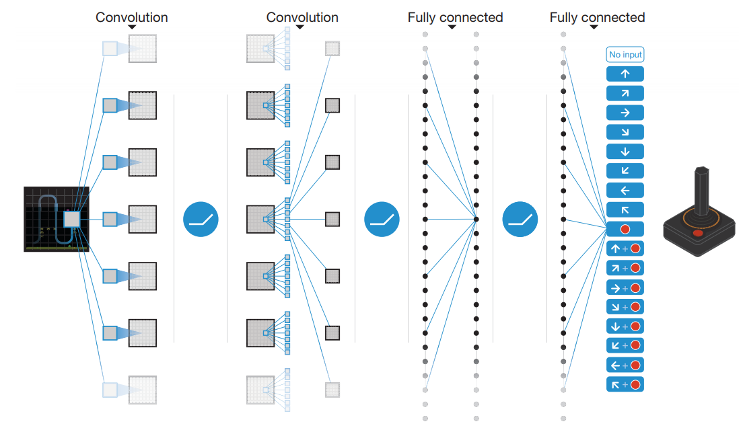

In [ ]:
class atariAgent():
    """ Atari Agent contains the model and functions to predict and train the agent"""
    def __init__(self,totalActions,scope = "agent"):
        self.scope = scope
        self.totalActions = totalActions
        with tf.variable_scope(self.scope):
            self.QModel()
    
    def QModel(self):
        """Contains the model"""
        self.Xin = tf.placeholder(shape=[None,84,84,4],dtype=tf.uint8,name='Xin')
        self.y = tf.placeholder(shape=[None],dtype=tf.float32,name='yin')
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32,name='actions')
        
        X = tf.to_float(self.Xin) / 255.0 # scale to [0,1]
        
        # model starts
        conv1 = tf.contrib.layers.conv2d(X,16,8,4,activation_fn=tf.nn.relu)
        
        conv2 = tf.contrib.layers.conv2d(conv1,32,4,2,activation_fn=tf.nn.relu)
        
        convOut = tf.contrib.layers.flatten(conv2)
        fc1 = tf.contrib.layers.fully_connected(convOut,256,activation_fn=tf.nn.relu)
        self.QValues = tf.contrib.layers.fully_connected(fc1,self.totalActions,activation_fn=None)
        
        batchSize = tf.shape(self.Xin)[0] 
        yIndices = tf.range(batchSize) * self.totalActions + self.actions
        self.predictedActions = tf.gather(tf.reshape(self.QValues,[-1]),yIndices)
        
        #c alculates loss function
        self.losses = tf.squared_difference(self.y, self.predictedActions)
        self.loss = tf.reduce_mean(self.losses)
        
        # training step
        self.optimizer = tf.train.RMSPropOptimizer(0.00025,0.99)
        self.trainStep = self.optimizer.minimize(self.loss, global_step=tf.train.get_global_step())
        
    def play(self,sess,states):
        """runs the model for the given state and predicts the Q values"""
        return sess.run(self.QValues,{self.Xin : states})
        
    def train(self,sess,states,y,actions):
        """Trains the Agent on the given input and target values and returns the loss
        """
        feed_dict = { self.Xin: states, self.y: y, self.actions: actions }
        loss, _ = sess.run([self.loss, self.trainStep],feed_dict)
        
        return loss

## Using Experience Replay

Using experience replay can make more efficient use of observed experience. Experience replay will help us to handle two things:

### Avoid forgetting previous experiences

At each time step, we receive a tuple (state, action, reward, new_state). We learn from it (we feed the tuple in our neural network), and then throw this experience. Our problem is that we give sequential samples from interactions with the environment to our neural network. And it tends to forget the previous experiences as it overwrites with new experiences For instance, if we are in the first level and then the second (which is totally different), our agent can forget how to behave in the first level.


Our solution: create a “replay buffer.” This stores experience tuples while interacting with the environment, and then we sample a small batch of tuple to feed our neural network. As a consequence, it can be more efficient to make use of previous experience, by learning with it multiple times.

Think of the replay buffer as a folder where every sheet is an experience tuple. You feed it by interacting with the environment. And then you take some random sheet to feed the neural network. This prevents the network from only learning about what it has immediately done.



In [ ]:
from collections import namedtuple,deque

def initExperienceReplay(env, initReplaySize: int, cell: namedtuple):
    replayBuffer = deque()
    state = env.reset()
    state = preprocess(state)
    state = np.stack([state]*4,axis=2)
    print("Filling Experience memory of the agent")
    for i in range(initReplaySize):
        action = env.action_space.sample()
        nextState, reward, isDone, _ = env.step(action)
        nextState = preprocess(nextState)
        nextState = np.append(state[:,:,1:],nextState[:,:,np.newaxis],axis=2) 
        replayBuffer.append(cell(state,reward,action,nextState,isDone))
        if(isDone):
            state = env.reset()
            state = preprocess(state)
            state = np.stack([state]*4,axis=2)
        else:
            state = nextState
    
    env.close()
    print("Filled memory of size {}".format(len(replayBuffer)))       
    return replayBuffer

## Using Separate Target Network

The third major addition to the DQN that makes it unique is the utilization of a second network during the training procedure. This second network is used to generate the target-Q values that will be used to compute the loss for every action during training. 

### Why not use just use one network for both estimations?

The issue is that at every step of training, the Q-network’s values shift, and if we are using a constantly shifting set of values to adjust our network values, then the value estimations can easily spiral out of control. The network can become destabilized by falling into feedback loops between the target and estimated Q-values. In order to mitigate that risk, the target network’s weights are fixed, and only periodically or slowly updated to the primary Q-networks values. In this way training can proceed in a more stable manner.

In [ ]:
def copyParameters(sess,targetModel,QModel):
    params1 = [var for var in tf.trainable_variables() if var.name.startswith(targetModel.scope)]
    params1 = sorted(params1,key=lambda var: var.name)
    params2 = [var for var in tf.trainable_variables() if var.name.startswith(QModel.scope)]
    params2 = sorted(params2,key=lambda var: var.name)
    copies = []
    for p1,p2 in zip(params1,params2):
        copy = p1.assign(p2)
        copies.append(copy)
    sess.run(copies)

## Action Selection

Still simply using the $\epsilon$-greedy policy.

In [ ]:
def EGreedyPolicy(epsilon,QValues):
    numActions = QValues.shape[1]
    probs = np.ones(numActions, dtype=float) * epsilon / numActions
    best_action = np.argmax(QValues)
    
    probs[best_action] += (1.0 - epsilon)
    
    optimizedAction = np.random.choice(numActions,p=probs)
    return optimizedAction

## Train It

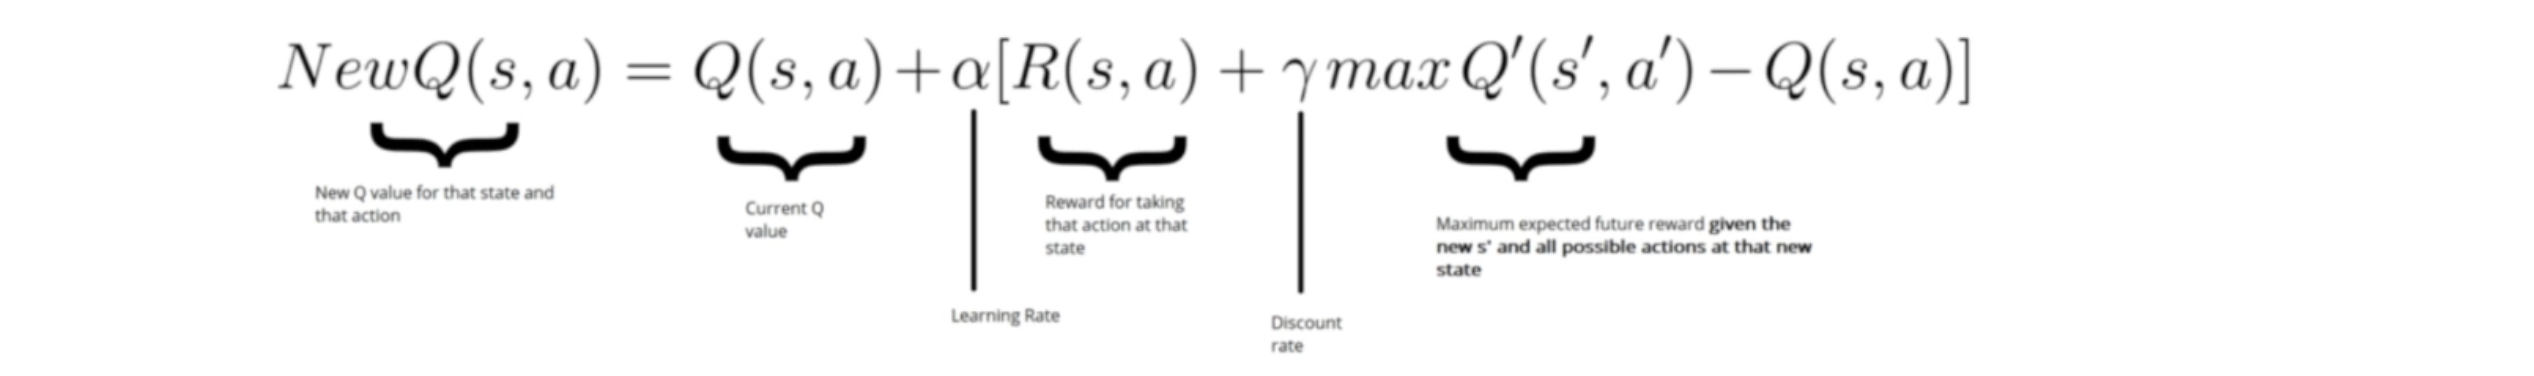

In [ ]:
numEpisodes = 1000  # determines the number of episode
initReplaySize = 5000
replaySize = 10000
batchSize = 32
startE = 1.0  # for epsilon decay, start from 1.0
endE = 0.1  # for epsilon decay, end with 0.1
annealingSteps = 5000  # for epsilon decay, determines the decay step
copyFrequency = 10000  # determines the update frequency
videoFrequency = 5000
discountFactor = 0.99  # discounted factor
checkpointDir = "checkpoint"
monitorDir = "monitor"

In [ ]:
from gym.wrappers import Monitor  # an environment wrapper, for recording

def trainAgent():
    #start environment
    env = gym.make('BreakoutDeterministic-v4')
    
    totalActions = env.action_space.n
    
    tf.reset_default_graph()
    
    # initialize target and evaluation model
    targetModel = atariAgent(totalActions,scope="targetModel")
    QModel = atariAgent(totalActions,scope="QModel")
    
    if not os.path.exists(checkpointDir):
        os.makedirs(checkpointDir)
    if not os.path.exists(monitorDir):
        os.makedirs(monitorDir)
    
    checkpoint = os.path.join(checkpointDir,"model")
    monitor = os.path.join(monitorDir,"game")
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        env = Monitor(env, directory=monitor, video_callable=lambda totalStep: totalStep % \
                      videoFrequency==0, resume=True)
        
        state = env.reset()
        
        ckpt = tf.train.latest_checkpoint(checkpointDir)
        if ckpt:
            saver.restore(sess,ckpt)
            totalStep = 0
            print("Existing checkpoint {} restored...".format(ckpt))
        else:
            totalStep = 0
        
        cell = namedtuple("cell","state reward action nextState isDone")
        
        replayMemory = initExperienceReplay(env,initReplaySize,cell)
        
        epsilonValues = np.linspace(startE,endE,num=annealingSteps)
        
        episodeLengths = []
        episodeRewards = []
        
        print("\n---------- Main Loop ----------")
        
        for episode in range(numEpisodes):
            state = env.reset()
            state = preprocess(state)
            state = np.stack([state] * 4, axis=2)
            
            loss = None
            episodeLength = 0
            totalReward = 0.
            
            while(True):
                if(totalStep%copyFrequency == 0):
                    copyParameters(sess,targetModel,QModel)
                    print("\nTarget Model updated...")

                epsilon = epsilonValues[min(totalStep, annealingSteps-1)]
                QValues = QModel.play(sess,np.expand_dims(state,0))
                bestAction = EGreedyPolicy(epsilon,QValues)

                nextState,reward,isDone,_ = env.step(bestAction)
                nextState = preprocess(nextState)
                nextState = np.append(state[:,:,1:],nextState[:,:,np.newaxis],axis=2)
                
                totalReward += reward
                
                if(len(replayMemory) == replaySize):
                    replayMemory.popleft()
                
                replayMemory.append(cell(state,reward,bestAction,nextState,isDone))

                indices = np.random.choice(len(replayMemory)-1,batchSize,replace=False)
                batch = [replayMemory[i] for i in indices]
                states,rewards,actions,nextStates,isDones = map(np.array,zip(*batch))
                
                # targetmodel prediction
                tQValues = targetModel.play(sess,nextStates)
                targetY = rewards + (1 - isDones) * discountFactor * np.amax(tQValues,axis=1)

                # gradient descent step
                loss = QModel.train(sess,states,targetY,actions)
                episodeLength += 1
                totalStep += 1
                
                if(isDone):
                    episodeRewards.append(reward)
                    episodeLengths.append(episodeLength)
                    print("\r[Episode {}]\tGlobal step: {} Final reward: {} Total reward: {} episode length: {} loss: {}"\
                          .format(episode,totalStep,reward,totalReward,episodeLength,loss), end="", flush=True)
                    
                    saver.save(tf.get_default_session(), checkpoint)
                    break
                    
                else:
                    state = nextState
                    totalStep += 1

In [ ]:
# ready for training
!apt install -y ffmpeg

In [ ]:
trainAgent()

## Google's Video

Google DeepMind's Deep Q-learning playing Atari Breakout

https://www.youtube.com/watch?v=V1eYniJ0Rnk